# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


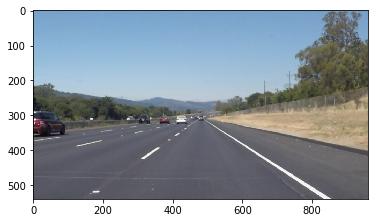

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [ ]:
image.shape

(540, 960, 3)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [ ]:
from __future__ import division
import math


def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.   
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """  
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    
    #linear Regression
    num_points_lh = 0.0
    num_points_rh = 0.0

    sum_lh_xi_yi =0.0
    sum_lh_xi =0.0
    sum_lh_yi =0.0
    sum_lh_xisq = 0.0
    
    sum_rh_xi_yi =0.0
    sum_rh_xi =0.0
    sum_rh_yi =0.0
    sum_rh_xisq = 0.0

    # region of interest
    imshape = img.shape
    y0_lh = imshape[0]
    y3_lh = int(imshape[0]/1.6)
    edge_lh_min = int(0.1*imshape[1])
    edge_lh = int(0.25*imshape[1])
    
    y0_rh = imshape[0]
    y3_rh = int(imshape[0]/1.6)
    edge_rh = int(0.95*imshape[1])
    edge_rh_min =  int(0.84*imshape[1])

# defining global values
    global b_mean_lh_old
    global a_mean_lh_old
    global b_mean_rh_old
    global a_mean_rh_old
    
# defining damping value
    damp = 0.15
#    damp = 0.15
    
#Separate lines neg/pos slope 
    for line in lines:
        for x1,y1,x2,y2 in line:
# Calculate of each point-pair slope, intersection and x0 at y0
            slope_calc = ((y2-y1)/(x2-x1))
            a_calc = y1 - slope_calc*x1
            x0_prog = (y0_lh-a_calc)/slope_calc

# Filter out lines only with unreasonable slope
            if slope_calc < -0.55 and slope_calc > -0.85 :
# Filter out parallel shifted lines:
                if x0_prog > edge_lh_min and x0_prog < edge_lh:
# Calculate terms for linear regression
                    num_points_lh +=2.0
                    sum_lh_xi_yi +=(x1*y1)
                    sum_lh_xi_yi +=(x2*y2)
                    sum_lh_xi +=(x1+x2)
                    sum_lh_xisq +=(x1*x1)
                    sum_lh_xisq +=(x2*x2)
                    sum_lh_yi += (y1+y2)
# Filter out lines only with unreasonable slope
            elif slope_calc > 0.49 and slope_calc < 0.7:
# Filter out parallel shifted lines:
                if x0_prog < edge_rh and x0_prog > edge_rh_min:
# Calculate terms for linear regression
                    num_points_rh +=2.0
                    sum_rh_xi_yi +=(x1*y1)
                    sum_rh_xi_yi +=(x2*y2)
                    sum_rh_xi += (x1+x2)
                    sum_rh_xisq +=(x1*x1)
                    sum_rh_xisq +=(x2*x2)
                    sum_rh_yi += (y1+y2)
                

# Calculate the mean slope and the intercept point of all lines on left side linear regression
# Are points on this side?       
    if num_points_lh > 0:
        b_mean_lh = (sum_lh_xi_yi-(1/num_points_lh)*sum_lh_xi*sum_lh_yi)/\
                    (sum_lh_xisq-(1/num_points_lh)*sum_lh_xi*sum_lh_xi)
        a_mean_lh = (1/num_points_lh)* sum_lh_yi -  b_mean_lh *(1/num_points_lh)* sum_lh_xi
# Start loop
        if b_mean_lh_old == 0.0:
            b_mean_lh_old = b_mean_lh
            a_mean_lh_old = a_mean_lh           
# Following loops
        else:
# Calculate new sloope and intersection point with damping and considering old values
            b_mean_lh = b_mean_lh_old + (damp)*(b_mean_lh-b_mean_lh_old)
            a_mean_lh = a_mean_lh_old + (damp)*(a_mean_lh-a_mean_lh_old)
            b_mean_lh_old = b_mean_lh
            a_mean_lh_old = a_mean_lh
# Calculate the intersection point at give y point in the range of interest
        x0_lh = int((y0_lh-a_mean_lh)/b_mean_lh)
        x3_lh = int((y3_lh-a_mean_lh)/b_mean_lh)
# Show lines in image with different colours left/right
        cv2.line(img, (x0_lh,y0_lh ), (x3_lh,y3_lh ), color=[2, 174, 0], thickness=5)
# No clear picture visible, but the step before => keep b_mean and a_mean constant    
    else:
        if b_mean_lh_old != 0:
            b_mean_lh = b_mean_lh_old
            a_mean_lh = a_mean_lh_old
# Calculate the intersection point at give y point in the range of interest
            x0_lh = int((y0_lh-a_mean_lh)/b_mean_lh)
            x3_lh = int((y3_lh-a_mean_lh)/b_mean_lh)
# Show lines in image with different colours left/right
            cv2.line(img, (x0_lh,y0_lh ), (x3_lh,y3_lh ), color=[2, 174, 0], thickness=5)
        
        
# Calculate the mean slope and the intercept point of all lines on right side linear regression
# Are points on this side?    
    if num_points_rh > 0:
        b_mean_rh = (sum_rh_xi_yi-(1/num_points_rh)*sum_rh_xi*sum_rh_yi)/\
                    (sum_rh_xisq-(1/num_points_rh)*sum_rh_xi*sum_rh_xi)
        a_mean_rh = (1/num_points_rh)* sum_rh_yi -  b_mean_rh *(1/num_points_rh)* sum_rh_xi
# Start loop
        if b_mean_rh_old == 0.0:
            b_mean_rh_old = b_mean_rh
            a_mean_rh_old = a_mean_rh           
# Following loops
        else:
# Calculate new sloope and intersection point with damping and considering old values
            b_mean_rh = b_mean_rh_old + (damp)*(b_mean_rh-b_mean_rh_old)
            a_mean_rh = a_mean_rh_old + (damp)*(a_mean_rh-a_mean_rh_old)
            b_mean_rh_old = b_mean_rh
            a_mean_rh_old = a_mean_rh
# Calculate the intersection point at give y point in the range of interest
        x0_rh = int((y0_rh-a_mean_rh)/b_mean_rh)
        x3_rh = int((y3_rh-a_mean_rh)/b_mean_rh)
# Show lines in image with different colours left/right
        cv2.line(img, (x0_rh,y0_rh ), (x3_rh,y3_rh ), color=[174, 2, 0], thickness=5)
# No clear picture visible, but the step before => keep b_mean and a_mean constant
    else:
        if b_mean_rh_old != 0: 
            b_mean_rh = b_mean_rh_old
            a_mean_rh = a_mean_rh_old
# Calculate the intersection point at give y point in the range of interest
            x0_rh = int((y0_rh-a_mean_rh)/b_mean_rh)
            x3_rh = int((y3_rh-a_mean_rh)/b_mean_rh)
# Show lines in image with different colours left/right
            cv2.line(img, (x0_rh,y0_rh ), (x3_rh,y3_rh ), color=[174, 2, 0], thickness=5)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.   
    Returns an image with hough lines drawn.
    """

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# only, if there is a yellow or white line
    if lines is not None:
        draw_lines(line_img, lines)

    return line_img


def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.    
    `initial_img` should be the image before any processing.    
    The result image is computed as follows:   
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

['lines_lines_lines_lines_solidWhiteCurve.jpg',
 'lines_lines_lines_lines_solidWhiteRight.jpg',
 'lines_lines_lines_lines_solidYellowCurve.jpg',
 'lines_lines_lines_lines_solidYellowCurve2.jpg',
 'lines_lines_lines_lines_solidYellowLeft.jpg',
 'lines_lines_lines_lines_whiteCarLaneSwitch.jpg',
 'lines_lines_lines_solidWhiteCurve.jpg',
 'lines_lines_lines_solidWhiteRight.jpg',
 'lines_lines_lines_solidYellowCurve.jpg',
 'lines_lines_lines_solidYellowCurve2.jpg',
 'lines_lines_lines_solidYellowLeft.jpg',
 'lines_lines_lines_whiteCarLaneSwitch.jpg',
 'lines_lines_solidWhiteCurve.jpg',
 'lines_lines_solidWhiteRight.jpg',
 'lines_lines_solidYellowCurve.jpg',
 'lines_lines_solidYellowCurve2.jpg',
 'lines_lines_solidYellowLeft.jpg',
 'lines_lines_whiteCarLaneSwitch.jpg',
 'lines_solidWhiteCurve.jpg',
 'lines_solidWhiteRight.jpg',
 'lines_solidYellowCurve.jpg',
 'lines_solidYellowCurve2.jpg',
 'lines_solidYellowLeft.jpg',
 'lines_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRigh

In [ ]:
image = mpimg.imread("test_images/"+ os.listdir("test_images/")[0])

In [ ]:
image_w = np.copy(image)

In [ ]:
image_w = grayscale(image_w)

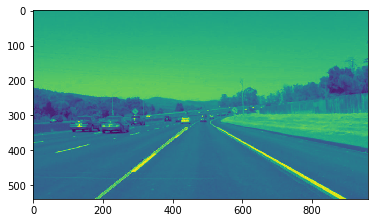

In [ ]:
plt.imshow(image_w)

In [ ]:
blur_gray_y = gaussian_blur(image_w, 5)

In [ ]:
edges_y = canny(blur_gray_y, 50, 160)

In [ ]:
plt.imshow(lines_img_y)

NameError: name 'lines_img_y' is not defined

In [ ]:
lines_img_y = hough_lines(edges_y, 1, np.pi/150, 8, 12, 10)

C:\Users\hyzy\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\hyzy\anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in int_scalars
C:\Users\hyzy\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


NameError: name 'b_mean_lh_old' is not defined

In [ ]:
red_threshold = 180
green_threshold = 180
blue_threshold = 140
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
# Identify pixels below the threshold
thresholds = (image_y[:,:,0] < rgb_threshold[0]) \
                & (image_y[:,:,1] < rgb_threshold[1]) \
                |(image_y[:,:,2] > rgb_threshold[2])

NameError: name 'image_y' is not defined

In [ ]:
image_w[thresholds] = [0,0,0]

NameError: name 'thresholds' is not defined

run your solution on all test_images and make copies into the test_images directory).

C:\Users\hyzy\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars


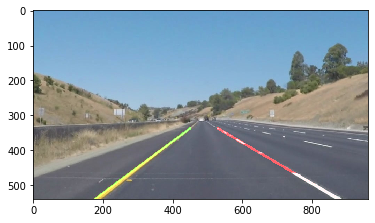

In [ ]:
# Pipeline that will draw lane lines on the test_images
# then saves them to the test_images directory.
from __future__ import division

pict_list = os.listdir("test_images/")
for pict in pict_list:
# Start values for global var
    b_mean_lh_old = 0.0
    a_mean_lh_old = 0.0
    b_mean_rh_old = 0.0
    a_mean_rh_old = 0.0
    
    # Read in and grayscale the image
    image_2 = mpimg.imread("test_images/"+pict)
    image_w = np.copy(image_2)
    image_y = np.copy(image_2)
    
    color_select = np.copy(image_2)
# Define color selection criteria - yellow colour
    red_threshold = 180
    green_threshold = 180
    blue_threshold = 140
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels below the threshold
    thresholds = (image_y[:,:,0] < rgb_threshold[0]) \
                & (image_y[:,:,1] < rgb_threshold[1]) \
                |(image_y[:,:,2] > rgb_threshold[2])
    color_select[thresholds] = [0,0,0]

    red_threshold = 220
    green_threshold = 220
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels above the threshold
    thresholds = (image_y[:,:,0] > rgb_threshold[0]) \
                & (image_y[:,:,1] > rgb_threshold[1]) 
    color_select[thresholds] = [0,0,0]                 
                  
    image_y = np.copy(color_select)

    color_select = np.copy(image_2)
# Define color selection criteria - white colour
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels below the threshold
    thresholds = (image_w[:,:,0] < rgb_threshold[0]) \
                | (image_w[:,:,1] < rgb_threshold[1]) \
                | (image_w[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    image_w = np.copy(color_select)
    
    gray_w = grayscale(image_w)
    gray_y = grayscale(image_y)
  
 # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
#    blur_gray = gaussian_blur(gray, kernel_size)
    blur_gray_y = gaussian_blur(gray_y, kernel_size)
    blur_gray_w = gaussian_blur(gray_w, kernel_size)

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 160
#    edges = canny(blur_gray, low_threshold, high_threshold)
    edges_y = canny(blur_gray_y, low_threshold, high_threshold)
    edges_w = canny(blur_gray_w, low_threshold, high_threshold)    



    # Defining a four sided polygon to mask
    imshape = image_2.shape
    vertices = np.array([[(0.1*imshape[1],imshape[0]),(0.48*imshape[1], imshape[0]/1.7), \
            (0.52*imshape[1], imshape[0]/1.7), (0.95*imshape[1],imshape[0])]], dtype=np.int32)
    # Create a masked edges image using cv2.fillPoly()
    masked_edges_w = region_of_interest(edges_w, vertices)
    masked_edges_y = region_of_interest(edges_y, vertices)

    # Define the Hough transform parameters
   
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/150 # angular resolution in radians of the Hough grid
    threshold = 8     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 12 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments


    # Run Hough on edge detected image
#    lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    lines_img_y = hough_lines(masked_edges_y, rho, theta, threshold, min_line_length, max_line_gap)
    lines_img_w = hough_lines(masked_edges_w, rho, theta, threshold, min_line_length, max_line_gap)
# Add lines together
    lines_img = cv2.addWeighted(lines_img_y, 1.0,  lines_img_w, 1.0, 0)   
    lines_edges = cv2.addWeighted(image_2, 1.0,  lines_img, 1.0, 0)
    plt.imshow(lines_edges)
    mpimg.imsave("test_images/lines_"+pict,lines_edges)

Image  lines_solidWhiteCurve.jpg  has dimensions:  (540, 960, 4)
Image  lines_solidWhiteRight.jpg  has dimensions:  (540, 960, 4)
Image  lines_solidYellowCurve.jpg  has dimensions:  (540, 960, 4)
Image  lines_solidYellowCurve2.jpg  has dimensions:  (540, 960, 4)
Image  lines_solidYellowLeft.jpg  has dimensions:  (540, 960, 4)
Image  lines_whiteCarLaneSwitch.jpg  has dimensions:  (540, 960, 4)


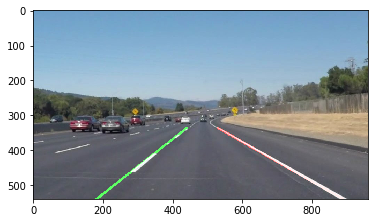

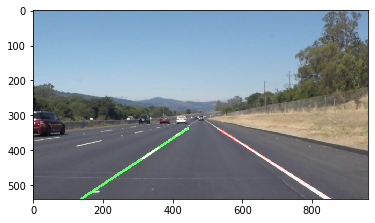

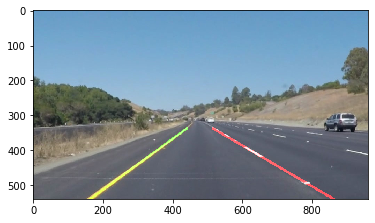

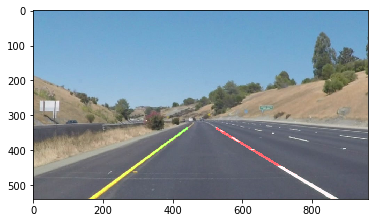

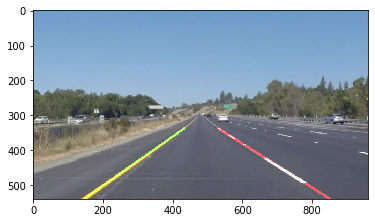

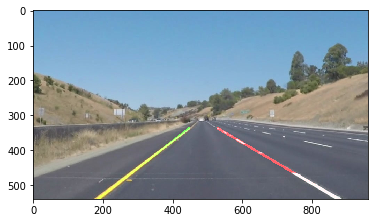

In [ ]:
# loop through and display all of the process images
import os
import re

pict_list = os.listdir("results/")
for pict in pict_list:
    # Read in the images
    if "jpg" in pict:
        image = mpimg.imread("results/"+pict)
        # print information
        print('Image ', pict, ' has dimensions: ', image.shape)
        # next image
        plt.figure()    
        # plot the image
        plt.imshow(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
from __future__ import division
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
# Start values for global var
    b_mean_lh_old = 0.0
    a_mean_lh_old = 0.0
    b_mean_rh_old = 0.0
    a_mean_rh_old = 0.0
    
    # Read in image
    image_2 = np.copy(image)
    image_w = np.copy(image_2)
    image_y = np.copy(image_2)
    
    color_select = np.copy(image_2)
# Define color selection criteria - yellow colour
    red_threshold = 180
    green_threshold = 180
    blue_threshold = 140
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels below the threshold
    thresholds = (image_y[:,:,0] < rgb_threshold[0]) \
                & (image_y[:,:,1] < rgb_threshold[1]) \
                |(image_y[:,:,2] > rgb_threshold[2])
    color_select[thresholds] = [0,0,0]

    red_threshold = 220
    green_threshold = 220
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels above the threshold
    thresholds = (image_y[:,:,0] > rgb_threshold[0]) \
                & (image_y[:,:,1] > rgb_threshold[1]) 
    color_select[thresholds] = [0,0,0]                 
                  
    image_y = np.copy(color_select)

    color_select = np.copy(image_2)
# Define color selection criteria - white colour
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Identify pixels below the threshold
    thresholds = (image_w[:,:,0] < rgb_threshold[0]) \
                | (image_w[:,:,1] < rgb_threshold[1]) \
                | (image_w[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    image_w = np.copy(color_select)
    
#   grayscale both images    
    gray_w = grayscale(image_w)
    gray_y = grayscale(image_y)

# Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
#    blur_gray = gaussian_blur(gray, kernel_size)
    blur_gray_y = gaussian_blur(gray_y, kernel_size)
    blur_gray_w = gaussian_blur(gray_w, kernel_size)

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 160

    edges_y = canny(blur_gray_y, low_threshold, high_threshold)
    edges_w = canny(blur_gray_w, low_threshold, high_threshold)    



    # Defining a four sided polygon to mask
    imshape = image_2.shape
    vertices = np.array([[(0.1*imshape[1],imshape[0]),(0.48*imshape[1], imshape[0]/1.7), \
            (0.52*imshape[1], imshape[0]/1.7), (0.95*imshape[1],imshape[0])]], dtype=np.int32)

    # Create a masked edges image using cv2.fillPoly()
    masked_edges_w = region_of_interest(edges_w, vertices)
    masked_edges_y = region_of_interest(edges_y, vertices)

    # Define the Hough transform parameters
   
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/150 # angular resolution in radians of the Hough grid
    threshold = 8     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 12 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments


    # Run Hough on edge detected image
#    lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    lines_img_y = hough_lines(masked_edges_y, rho, theta, threshold, min_line_length, max_line_gap)
    lines_img_w = hough_lines(masked_edges_w, rho, theta, threshold, min_line_length, max_line_gap)
# Add lines together
    lines_img = cv2.addWeighted(lines_img_y, 1.0,  lines_img_w, 1.0, 0)   
    lines_edges = cv2.addWeighted(image_2, 1.0,  lines_img, 1.0, 0)   
    
    return lines_edges[:,:,[0,1,2]]

Let's try the one with the solid white lane on the right first ...

In [ ]:
b_mean_lh_old = 0.0
a_mean_lh_old = 0.0
b_mean_rh_old = 0.0
a_mean_rh_old = 0.0
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: MoviePy error: the file solidWhiteRight.mp4 could not be found!
Please check that you entered the correct path.

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
b_mean_lh_old = 0.0
a_mean_lh_old = 0.0
b_mean_rh_old = 0.0
a_mean_rh_old = 0.0
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:57<00:00,  7.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 59s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

1. coding improvment => using polyfit, LinearRegression
2. deal with outliers => points lying more or less fare away from "desired" line => distortion of calculated line => better using M-estimator => weighted residuals
3. for better curve fitting, use polynomes higher grades => prevent overfitting with cross-validation, keeping some data points as training data other for generalization (test data) => cross_val_score
4. use RANSAC “RANdom SAmple Consensus”, random selection some point => calculate LS model with some poynomial grade => count all data points lying within a given limit => loop that k times and take the model with the highst number of points lying within the given limit
5. calculate length of the line segments found with hough transform => ignore shorter pieces
6. take more history points into account, optionally wth weights over time
7. take more color layer to be more robust
8. transform to HSV colour table => hue, saturation and value
9. deal with no clear picture (shadows, light reflection etc. over a longer period => orientation at other edges)


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
b_mean_lh_old = 0.0
a_mean_lh_old = 0.0
b_mean_rh_old = 0.0
a_mean_rh_old = 0.0
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:34<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 1min 38s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))